<a href="https://colab.research.google.com/github/channeladam/MOOCs/blob/master/SchoolOfAI/DataLit/Week06/DataLit_W6_7_MidTerm_Stock_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Assignment Details

Linear Regression for Price Prediction

Write a Python script that uses linear regression to predict the price of a stock. Pick any company you’d like.

- I'm choosing Apple Stock as it one of my favorite company.

This is a fun exercise to learn about data preprocessing, python, and using machine learning libraries like sci-kit learn.


In [1]:
!pip install -U seaborn


Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.9.0)


In [0]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import scipy as sp
from scipy.stats import norm

from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score, make_scorer, mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from IPython.core.pylabtools import figsize

import seaborn as sns
sns.set(style='whitegrid')

# Helpers

def map_correlation(df):
  corrmatrix = df.corr(method='pearson')
  mask = np.zeros_like(corrmatrix, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True
  f, ax = plt.subplots(figsize=(12,12))
  cmap = sns.cubehelix_palette(start=0.6, hue=3.7, rot=0.5, as_cmap=True)
  sns.heatmap(corrmatrix, mask=mask, cmap=cmap, vmin=0.2, square=True, ax=ax)
  return corrmatrix

def map_correlation_coeff(df, cols):
  cm = np.corrcoef(df[cols].values.T)
  sns.set(font_scale=1.5)
  hm = sns.heatmap(cm, cbar=True, annot=True, square=True, 
                   fmt='.2f', annot_kws={'size': 10}, 
                   yticklabels=cols.values, xticklabels=cols.values)
  plt.show()

def prediction_metrics(predictions, actual):
  mae = mean_absolute_error(actual, predictions)
  mse = mean_squared_error(actual, predictions)
  r2 = r2_score(actual, predictions)
  return mae, mse, r2
  
def draw_confusion_matrix(predictions, ground_truth):
  cfm = confusion_matrix(predictions, ground_truth)
  sns.heatmap(cfm, annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')

# Data Acquisition

In [3]:
!wget -N "https://raw.githubusercontent.com/jayeshsaini/Data-Lit/master/Week%206%20Mid-term%20Assignment/data/AAPL.csv"

--2019-03-26 19:20:11--  https://raw.githubusercontent.com/jayeshsaini/Data-Lit/master/Week%206%20Mid-term%20Assignment/data/AAPL.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75073 (73K) [text/plain]
Saving to: ‘AAPL.csv’

AAPL.csv            100%[===================>]  73.31K  --.-KB/s    in 0.01s   

Last-modified header missing -- time-stamps turned off.
2019-03-26 19:20:11 (5.04 MB/s) - ‘AAPL.csv’ saved [75073/75073]



# Exploratory Data Analysis

All the files have the following columns: 
- Date - in format: yy-mm-dd
- Open - price of the stock at market open (this is NYSE data so all in USD)
- High - Highest price reached in the day
- Low Close - Lowest price reached in the day
- Close - Closing price of the stock
- Adj Close - Adjusted Closing price of the stock based on business decisions (Will be dropped)
- Volume - Number of shares traded

In [0]:
data = pd.read_csv("AAPL.csv")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 7 columns):
Date         1007 non-null object
Open         1007 non-null float64
High         1007 non-null float64
Low          1007 non-null float64
Close        1007 non-null float64
Adj Close    1007 non-null float64
Volume       1007 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 55.1+ KB


In [6]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-03-26,122.7600,124.8800,122.6000,124.2400,115.8296,47572900
1,2015-03-27,124.5700,124.7000,122.9100,123.2500,114.9066,39546200
2,2015-03-30,124.0500,126.4000,124.0000,126.3700,117.8154,47099700
3,2015-03-31,126.0900,126.4900,124.3600,124.4300,116.0067,42090600
4,2015-04-01,124.8200,125.1200,123.1000,124.2500,115.8389,40621400


Open, high, low, close and volume are continuous.

## Data Cleansing

In [0]:
# We're only looking at stock closing price, so we can drop the adjusted price(Either of them needs to be predicted)
data.drop('Adj Close', axis=1, inplace=True)

In [8]:
# reconfirm the non-null status of columns from info()
data.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [0]:
# let's get a date datatype
data['Date'] = pd.to_datetime(data['Date'], yearfirst=True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 6 columns):
Date      1007 non-null datetime64[ns]
Open      1007 non-null float64
High      1007 non-null float64
Low       1007 non-null float64
Close     1007 non-null float64
Volume    1007 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 47.3 KB


## Train / Test Data Splitting

In [11]:
data.shape

(1007, 6)

In [0]:
length = data.shape[0]
train_size = int(length * 0.8)

train = data[:train_size]
test = data[train_size:]

In [13]:
train.shape

(805, 6)

In [14]:
train.iloc[train.shape[0]-1]

Date      2018-06-05 00:00:00
Open                 193.0700
High                 193.9400
Low                  192.3600
Close                193.3100
Volume               21566000
Name: 804, dtype: object

In [16]:
test.shape

(202, 6)

In [17]:
test.iloc[0]

Date      2018-06-06 00:00:00
Open                 193.6300
High                 194.0800
Low                  191.9200
Close                193.9800
Volume               20933600
Name: 805, dtype: object

train stops at 804, and test starts at 805.
Looks good.

## Train Data Analysis

Let's not have any data snooping bias by looking at our test data!

In [18]:
train.describe()

,Open,High,Low,Close,Volume
count,805.0000,805.0000,805.0000,805.0000,805.0000
mean,131.9427,133.0260,130.8869,131.9961,37030291.8012
std,27.0541,27.1985,26.9358,27.0662,18261027.5327
min,90.0000,91.6700,89.4700,90.3400,11475900.0000
25%,110.1200,111.1900,109.0200,109.9900,25124300.0000
50%,125.7200,126.4900,124.6600,125.6600,32527000.0000
75%,155.8000,156.4200,154.4800,155.4500,44392800.0000
max,193.0700,193.9400,192.3600,193.3100,162206300.0000


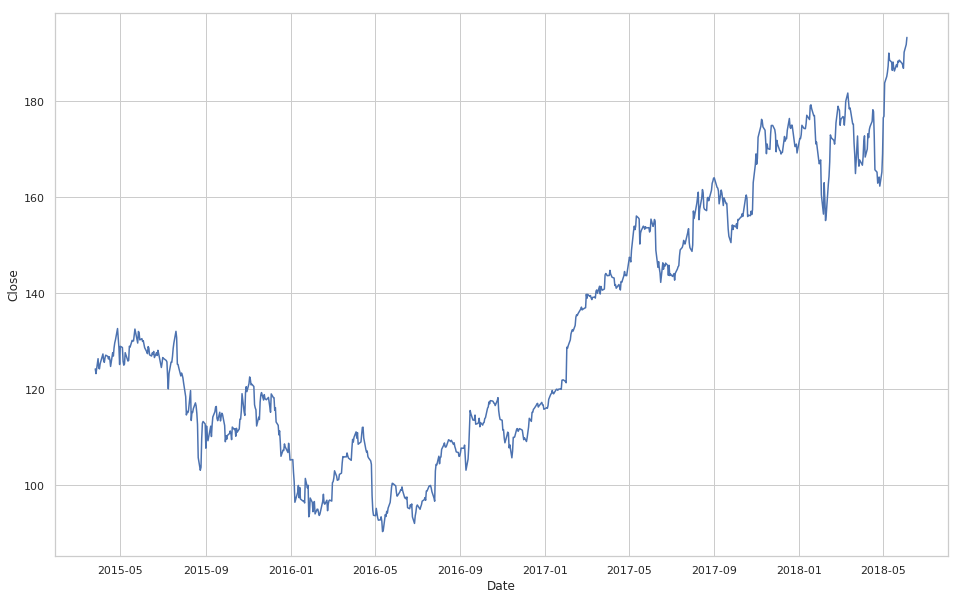

In [19]:
sns.lineplot(x='Date', y='Close', data=train)

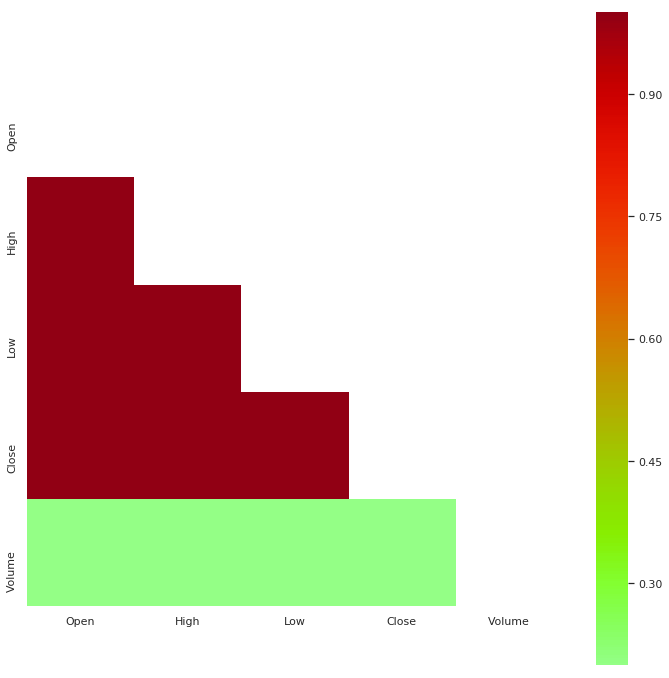

In [20]:
corrmatrix = map_correlation(train)

Close, low and high all correlate strongly... but nothing really does with volume

In [21]:
largest_corrs = corrmatrix.nlargest(10, 'Close')['Close']
largest_corrs

Close     1.0000
Low       0.9992
High      0.9992
Open      0.9984
Volume   -0.3093
Name: Close, dtype: float64

## Feature Engineering

Volume didn't correlate, so we'll have a look at doing something with that.

In [0]:

# 1 day Momentum
train['1d_momentum'] = train['Close'] - train['Close'].shift(1)
train['1d_momentum'].fillna(0, inplace=True)

# 5 day Momentum
train['5d_momentum'] = train['Close'] - train['Close'].shift(4)
train['5d_momentum'].fillna(0, inplace=True)

In [23]:
train.tail(10)

,Date,Open,High,Low,Close,Volume,1d_momentum,5d_momentum
795,2018-05-22,188.3800,188.8800,186.7800,187.1600,15240700,-0.4700,-1.0200
796,2018-05-23,186.3500,188.5000,185.7600,188.3600,20058400,1.2000,1.3700
797,2018-05-24,188.7700,188.8400,186.2100,188.1500,23234000,-0.2100,1.8400
798,2018-05-25,188.2300,189.6500,187.6500,188.5800,17461000,0.4300,0.9500
799,2018-05-29,187.6000,188.7500,186.8700,187.9000,22514100,-0.6800,0.7400
800,2018-05-30,187.7200,188.0000,186.7800,187.5000,18690500,-0.4000,-0.8600
801,2018-05-31,187.2200,188.2300,186.1400,186.8700,27482800,-0.6300,-1.2800
802,2018-06-01,187.9900,190.2600,187.7500,190.2400,23442500,3.3700,1.6600
803,2018-06-04,191.6400,193.4200,191.3500,191.8300,26266200,1.5900,3.9300
804,2018-06-05,193.0700,193.9400,192.3600,193.3100,21566000,1.4800,5.8100


In [24]:
test.head()

,Date,Open,High,Low,Close,Volume
805,2018-06-06,193.6300,194.0800,191.9200,193.9800,20933600
806,2018-06-07,194.1400,194.2000,192.3400,193.4600,21347200
807,2018-06-08,191.1700,192.0000,189.7700,191.7000,26656800
808,2018-06-11,191.3500,191.9700,190.2100,191.2300,18308500
809,2018-06-12,191.3900,192.6100,191.1500,192.2800,16911100


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3ea6f78048>,
      dtype=object)

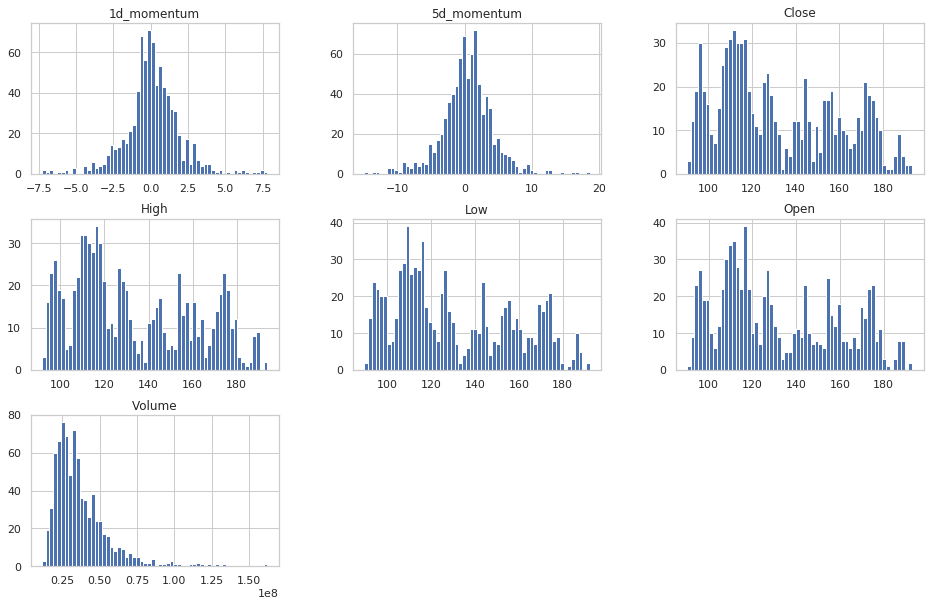

In [25]:
train.hist(bins=60)

Volume is positively skewed and normal distribution looking, so we could take the log of that

In [0]:
train['log_volume'] = np.log(train['Volume'])

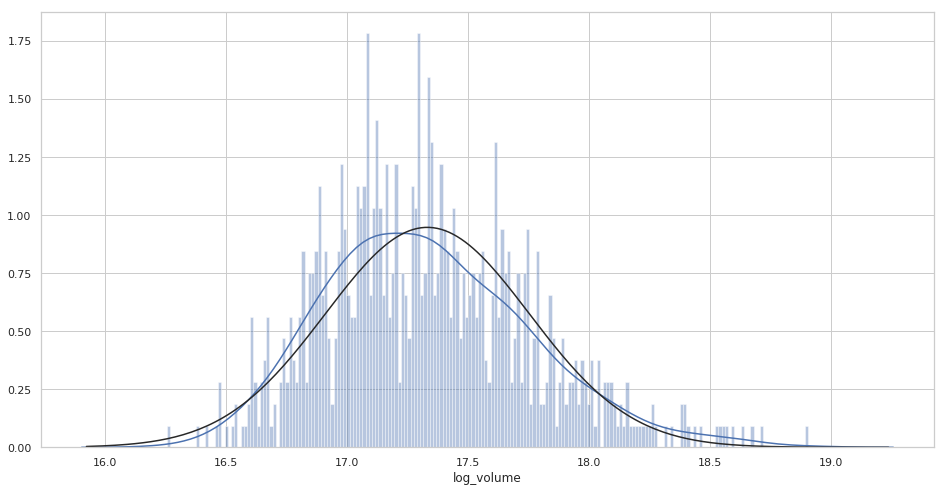

In [27]:
figsize(16,8)
sns.distplot(train['log_volume'], hist=True, bins=int(200), fit=norm)

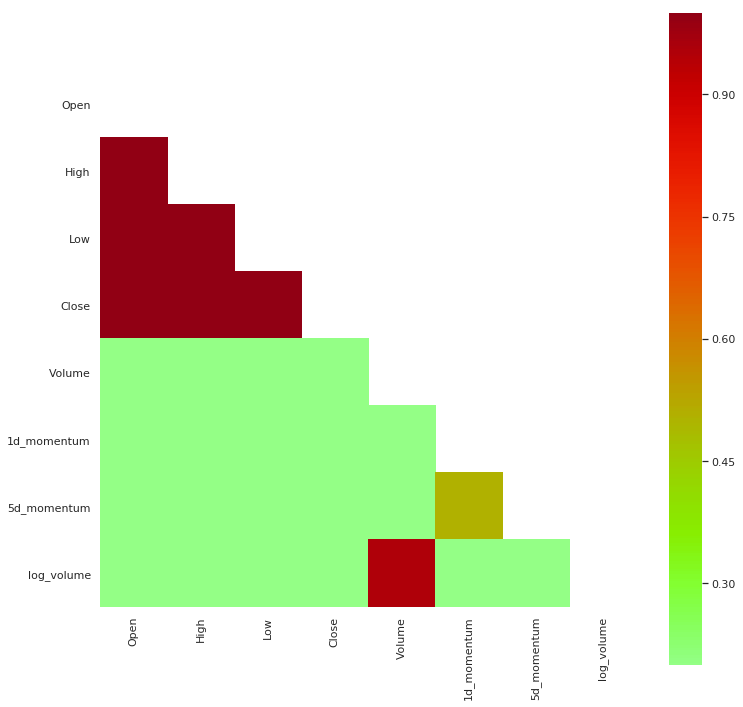

In [28]:
corrmatrix = map_correlation(train)

Okay, there is little correlation for volume, log_volume, or momentum.

In [29]:
largest_corrs = corrmatrix.nlargest(10, 'Close')['Close']
largest_corrs

Close          1.0000
Low            0.9992
High           0.9992
Open           0.9984
5d_momentum    0.1523
1d_momentum    0.0801
Volume        -0.3093
log_volume    -0.3491
Name: Close, dtype: float64

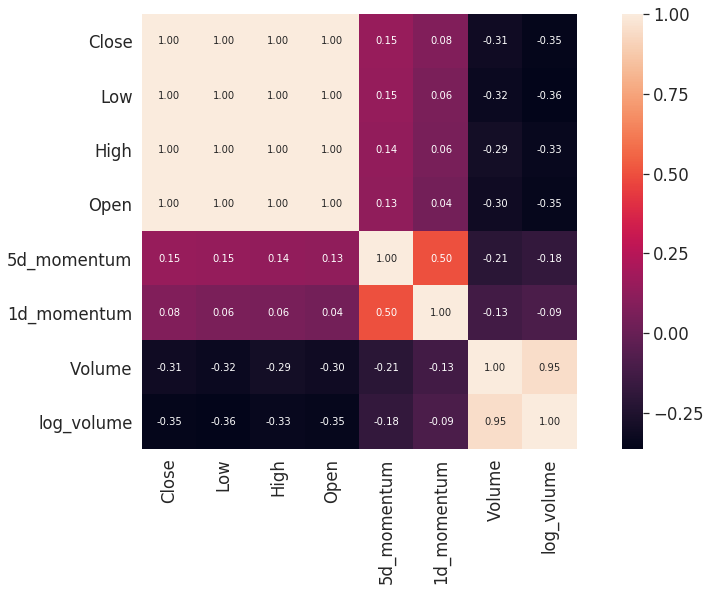

In [30]:
map_correlation_coeff(train, largest_corrs.index)

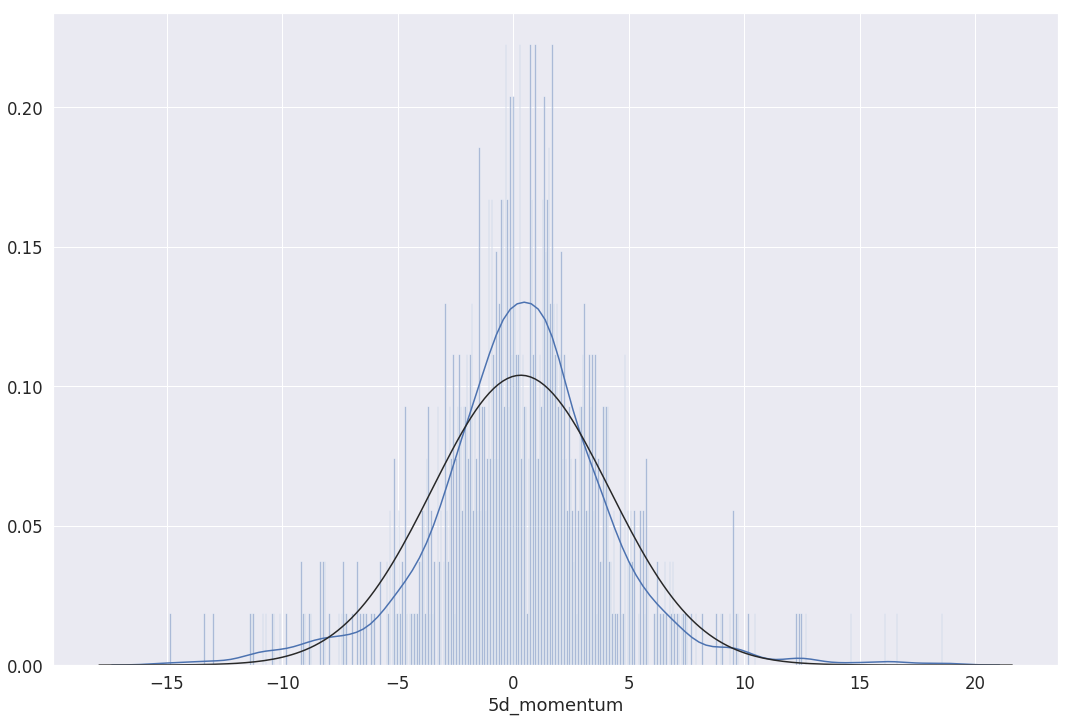

In [31]:
figsize(18,12)
sns.distplot(train['5d_momentum'], bins=500, hist=True, fit=norm)

Interesting how the 5 day momentum appears normal and generally normally distributed

# Regression

So we are going to predict the close price.

No one said we can't use the open, high and low prices for that prediction... in addition to the day.

(otherwise perhaps we might need time series analysis... maybe next week? :) 

## Prepare Data

In [32]:
cols_drop = largest_corrs[ largest_corrs.values < 0.5 ].index.tolist()
cols_drop.append('Close')
cols_drop.append('Date')
cols_drop

['5d_momentum', '1d_momentum', 'Volume', 'log_volume', 'Close', 'Date']

In [33]:
x_train = train.drop(cols_drop, axis=1)
x_train['Day'] = x_train.index

y_train = train['Close']

(x_train.shape, y_train.shape)

((805, 4), (805,))

In [34]:
x_train.tail()

,Open,High,Low,Day
800,187.7200,188.0000,186.7800,800
801,187.2200,188.2300,186.1400,801
802,187.9900,190.2600,187.7500,802
803,191.6400,193.4200,191.3500,803
804,193.0700,193.9400,192.3600,804


In [35]:
x_test = test.drop(['Close','Volume','Date'], axis=1)
x_test['Day'] = x_test.index

y_test = test['Close']

(x_test.shape, y_test.shape)

((202, 4), (202,))

In [36]:
x_test.head()

,Open,High,Low,Day
805,193.6300,194.0800,191.9200,805
806,194.1400,194.2000,192.3400,806
807,191.1700,192.0000,189.7700,807
808,191.3500,191.9700,190.2100,808
809,191.3900,192.6100,191.1500,809


## Linear Regression

In [51]:
from sklearn import linear_model

model = linear_model.LinearRegression()
model.fit(x_train, y_train)

train_pred = model.predict(x_train)

mae, mse, r2 = prediction_metrics(train_pred, y_train)
print("TRAIN: MAE", mae, "MSE", mse, "R2", r2)

test_pred = model.predict(x_test)
mae, mse, r2 = prediction_metrics(test_pred, y_test)
print("TEST: MAE", mae, "MSE", mse, "R2", r2)


TRAIN: MAE 0.47041603892741296 MSE 0.42325769273502983 R2 0.9994215156964421
TEST: MAE 0.8921109378903086 MSE 1.3686653402161557 R2 0.9974918987133117


R2 Looks good... the predictions are close to the regression line...


In [38]:
intercept = model.intercept_
coeffs = dict(zip(x_test.columns.tolist(), model.coef_))

print('intercept:', intercept)
print('coefficients:', coeffs)

intercept: 0.09428481413903
coefficients: {'Open': -0.5717268282366581, 'High': 0.797357236258089, 'Low': 0.773762279554092, 'Day': -1.872217447107527e-05}


Compare the actual close price with the predicted close... the blue and red:

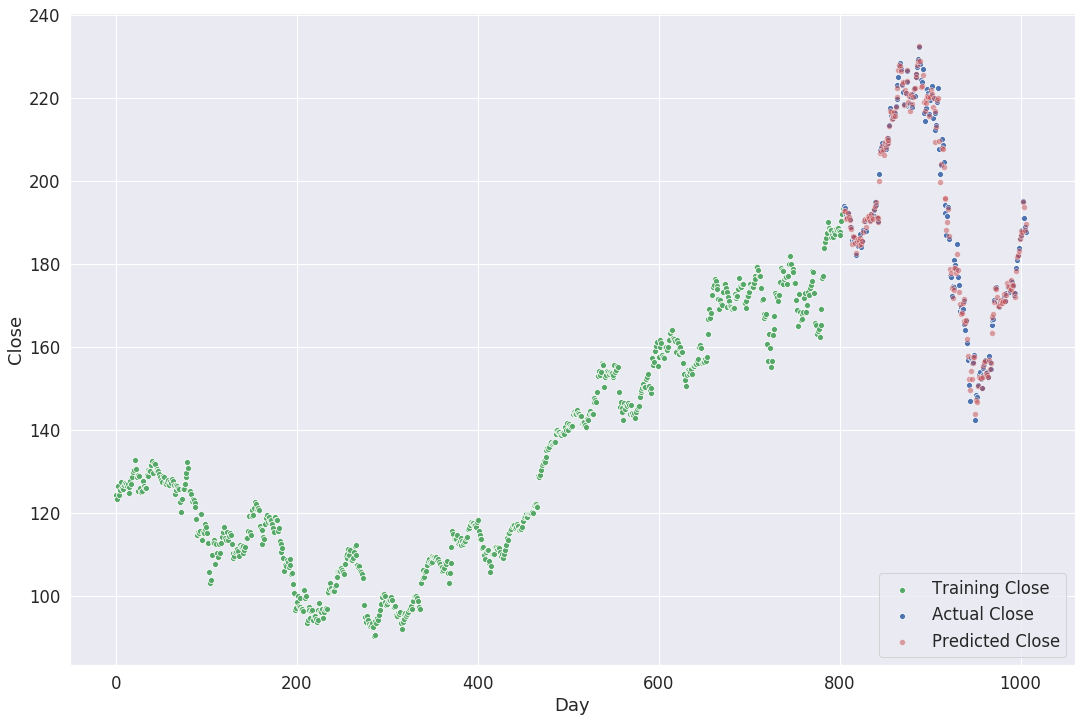

In [41]:
ax = sns.scatterplot(x=x_train.Day, y=y_train, color='g', label='Training Close')
plt.xlabel('Day')
plt.ylabel('Close Price')

sns.scatterplot(x=x_test.Day, y=y_test, color='b', label='Actual Close')

sns.scatterplot(x=x_test.Day, y=test_pred, color='r', label='Predicted Close', alpha=0.5)
#sns.lineplot(x=x_test.day, y=test_pred, color='r', label='Predicted Close', alpha=0.5)

ax.legend(loc='lower right')


And just for comparison, this is what the full original data looked like:

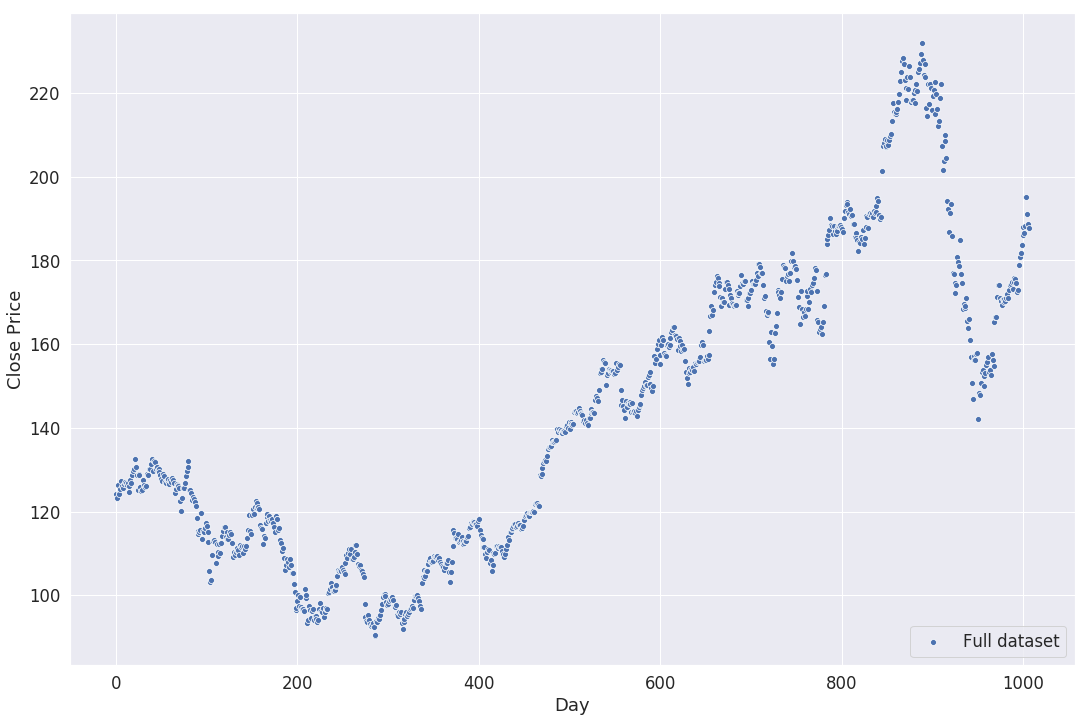

In [43]:
ax = sns.scatterplot(x=data.index, y=data.Close, label='Full dataset')
plt.xlabel('Day')
plt.ylabel('Close Price')
ax.legend(loc='lower right')


## Elastic Net Regression

Just out of curiosity... let's try Elastic Net


In [44]:
model = linear_model.ElasticNet(alpha=1, l1_ratio=0.5, normalize=False)
model.fit(x_train, y_train)

train_pred = model.predict(x_train)

mae, mse, r2 = prediction_metrics(train_pred, y_train)
print("TRAIN: MAE", mae, "MSE", mse, "R2", r2)

test_pred = model.predict(x_test)
mae, mse, r2 = prediction_metrics(test_pred, y_test)
print("TEST: MAE", mae, "MSE", mse, "R2", r2)


TRAIN: MAE 0.6036886905808284 MSE 0.6821865103833556 R2 0.9990676266607095
TEST: MAE 1.1172890562079454 MSE 2.1405622667965054 R2 0.9960773851592232


Doesn't appear to perform as well as the previous linear regressor.

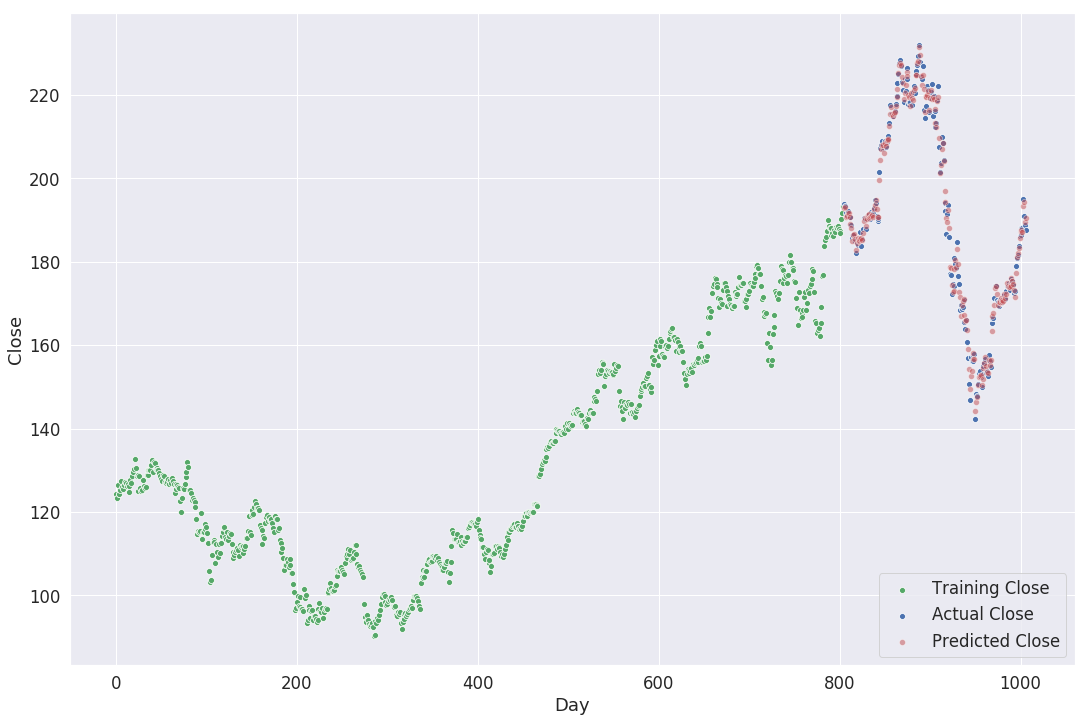

In [46]:
ax = sns.scatterplot(x=x_train.Day, y=y_train, color='g', label='Training Close')
plt.xlabel('Day')
plt.ylabel('Close Price')

sns.scatterplot(x=x_test.Day, y=y_test, color='b', label='Actual Close')

sns.scatterplot(x=x_test.Day, y=test_pred, color='r', label='Predicted Close', alpha=0.5)
#sns.lineplot(x=x_test.day, y=test_pred, color='r', label='Predicted Close', alpha=0.5)

ax.legend(loc='lower right')